In [1]:
import cv2
import os

# 비디오 파일들이 있는 폴더 경로
video_folder = r"C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\new_video_3"
# 추출된 이미지를 저장할 폴더 경로
save_folder = r"C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2"

# 저장 폴더가 없으면 생성
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# video_folder 내의 모든 mp4 파일 순회
for file in os.listdir(video_folder):
    if file.lower().endswith('.mp4'):
        video_path = os.path.join(video_folder, file)
        cap = cv2.VideoCapture(video_path)
        
        # 비디오의 FPS(초당 프레임 수)를 구함
        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps == 0:
            print(f"FPS가 0입니다. {file} 파일은 건너뜁니다.")
            continue
        
        # 0.1초당 1개의 프레임을 추출하므로, 매 (fps * 0.1) 프레임마다 저장
        frame_interval = int(round(fps * 0.5))
        if frame_interval < 1:
            frame_interval = 1  # 프레임 간격 최소 1
        
        frame_count = 0
        saved_frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # 0.1초마다 한 프레임 저장 (즉, frame_interval마다)
            if frame_count % frame_interval == 0:
                # 저장 파일 이름: 비디오 파일명과 프레임 번호를 조합
                frame_file_name = f"{os.path.splitext(file)[0]}_frame{frame_count}.jpg"
                frame_path = os.path.join(save_folder, frame_file_name)
                
                # imencode를 사용해 이미지를 JPEG 형식으로 인코딩
                success, encoded_image = cv2.imencode('.jpg', frame)
                if success:
                    try:
                        with open(frame_path, 'wb') as f:
                            f.write(encoded_image.tobytes())
                        print(f"Saved: {frame_path}")
                        saved_frame_count += 1
                    except Exception as e:
                        print(f"Failed to save: {frame_path}, error: {e}")
                else:
                    print(f"Failed to encode frame for: {frame_path}")
            
            frame_count += 1

        cap.release()
        print(f"{file} 파일에서 {saved_frame_count}개의 프레임을 추출했습니다.")


Saved: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_20250220_15_16_39_Pro_frame0.jpg
Saved: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_20250220_15_16_39_Pro_frame14.jpg
Saved: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_20250220_15_16_39_Pro_frame28.jpg
Saved: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_20250220_15_16_39_Pro_frame42.jpg
Saved: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_20250220_15_16_39_Pro_frame56.jpg
Saved: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_20250220_15_16_39_Pro_frame70.jpg
Saved: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_20250220_15_16_39_Pro_frame84.jpg
Saved: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데

In [3]:
import os
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
from PIL import Image

# === 설정 ===

'''
DETECTION_PREDICTION_KEY = ""
DETECTION_PREDICTION_ENDPOINT = ""
DETECTION_PROJECT_ID = ""
DETECTION_ITERATION_NAME = ""
'''

DETECTION_PREDICTION_KEY = "EAqbiKHt9sYSwFiO7U1NUBngdvnBoJRmd3ZLl0V0XzKkBbzibzPoJQQJ99BBACYeBjFXJ3w3AAAIACOGYNGQ"
DETECTION_PREDICTION_ENDPOINT = "https://6b034cv20250210-prediction.cognitiveservices.azure.com/"
DETECTION_PROJECT_ID = "5cd011c1-e369-47fd-9059-65cc46239b97"
DETECTION_ITERATION_NAME = "Iteration1"



# 입력 및 출력 폴더 경로
DETECTION_INPUT_FOLDER = r"C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2"
DETECTION_OUTPUT_FOLDER = r"C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\cropped_1sec_2"

# 출력 폴더 생성 (없으면 생성)
os.makedirs(DETECTION_OUTPUT_FOLDER, exist_ok=True)

# === Azure Custom Vision 예측 클라이언트 설정 ===
credentials = ApiKeyCredentials(in_headers={"Prediction-key": DETECTION_PREDICTION_KEY})
predictor = CustomVisionPredictionClient(DETECTION_PREDICTION_ENDPOINT, credentials)

def detect_and_crop_body(image_path, output_folder, threshold=0.5):
    """
    모델을 사용하여 'body' 태그만 감지하고, 크롭하여 저장하는 함수
    """
    with open(image_path, "rb") as image_data:
        results = predictor.detect_image(DETECTION_PROJECT_ID, DETECTION_ITERATION_NAME, image_data)

    # 원본 이미지 로드
    img = Image.open(image_path)
    width, height = img.size

    # 감지된 객체 중 'body'만 크롭
    for prediction in results.predictions:
        if prediction.probability >= threshold and prediction.tag_name == "Body":
            # 바운딩 박스 좌표 변환
            left = int(prediction.bounding_box.left * width)
            top = int(prediction.bounding_box.top * height)
            box_width = int(prediction.bounding_box.width * width)
            box_height = int(prediction.bounding_box.height * height)
            crop_box = (left, top, left + box_width, top + box_height)

            cropped_img = img.crop(crop_box)

            # 원본 파일명 유지
            output_filename = os.path.basename(image_path)  # ex) "image1.jpg"
            output_path = os.path.join(output_folder, output_filename)
            cropped_img.save(output_path)

            print(f"[✓] Cropped body saved to: {output_path}")
            return  # 첫 번째 'body'만 저장하고 종료

def process_images(input_folder, output_folder, threshold=0.5):
    """
    입력 폴더 내 모든 이미지를 처리하는 함수
    """
    for filename in os.listdir(input_folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(input_folder, filename)
            print(f"[*] Processing: {image_path}")
            detect_and_crop_body(image_path, output_folder, threshold)

# === 실행 ===
process_images(DETECTION_INPUT_FOLDER, DETECTION_OUTPUT_FOLDER, threshold=0.9)
print("[✓] 모든 'body' 크롭 이미지 처리가 완료되었습니다.")


[*] Processing: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_20250220_15_16_39_Pro_frame0.jpg
[✓] Cropped body saved to: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\cropped_1sec_2\WIN_20250220_15_16_39_Pro_frame0.jpg
[*] Processing: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_20250220_15_16_39_Pro_frame112.jpg
[✓] Cropped body saved to: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\cropped_1sec_2\WIN_20250220_15_16_39_Pro_frame112.jpg
[*] Processing: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_20250220_15_16_39_Pro_frame126.jpg
[✓] Cropped body saved to: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\cropped_1sec_2\WIN_20250220_15_16_39_Pro_frame126.jpg
[*] Processing: C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\noncropped_1sec_2\WIN_

0.0초: 운전하다 (KSS: 1), Probability: 99.97%
--------------------------------------------------
0.5초: 눈비비기 (KSS: 4), Probability: 100.00%
--------------------------------------------------
1.0초: 눈비비기 (KSS: 4), Probability: 100.00%
--------------------------------------------------
1.5초: 운전하다 (KSS: 1), Probability: 99.99%
--------------------------------------------------
2.0초: 눈비비기 (KSS: 4), Probability: 100.00%
--------------------------------------------------
2.5초: 눈비비기 (KSS: 4), Probability: 100.00%
최근 6프레임(약 3.0초) 평균 KSS: 3.00, 기울기: 0.69
→ 위험 상태: 위험(High)
--------------------------------------------------
3.0초: 눈비비기 (KSS: 4), Probability: 100.00%
최근 6프레임(약 3.0초) 평균 KSS: 3.50, 기울기: 0.17
→ 위험 상태: 주의(Moderate)
--------------------------------------------------
3.5초: 눈비비기 (KSS: 4), Probability: 100.00%
최근 6프레임(약 3.0초) 평균 KSS: 3.50, 기울기: 0.51
→ 위험 상태: 위험(High)
--------------------------------------------------
4.0초: 눈비비기 (KSS: 4), Probability: 100.00%
최근 6프레임(약 3.0초) 평균 KSS: 3.50, 기울기: 0.8

C:\Users\EL0017\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\EL0017\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\EL0017\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


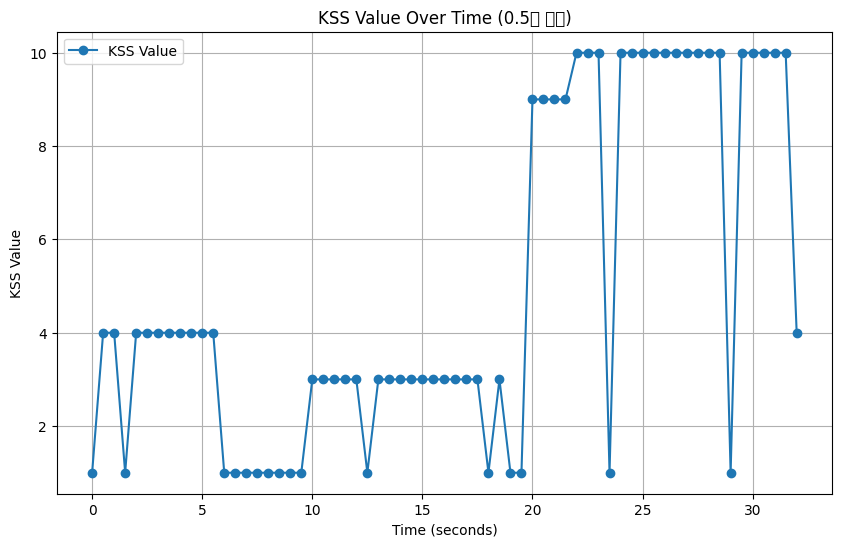

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials

# === Azure Custom Vision 설정 ===
classification_prediction_endpoint = "https://6b003cv20250210-prediction.cognitiveservices.azure.com"
classification_prediction_key = "8ypy2B3ZECnRG0PaYKzpSNvOz8yAhfF7MY2z2wQxSzkweNlhgI4SJQQJ99BBACYeBjFXJ3w3AAAIACOG0WmE"
classification_project_id = "03fa2862-cb54-4344-b484-630379edffaa"
classification_publish_iteration_name = "Iteration4"

credentials = ApiKeyCredentials(in_headers={"Prediction-key": classification_prediction_key})
predictor = CustomVisionPredictionClient(endpoint=classification_prediction_endpoint, credentials=credentials)

image_dir = r"C:\Users\EL0017\Downloads\089.차량 내 탑승자 상황 인식 영상 데이터\01.데이터\preject_test\cropped_1sec_2"

# --- KSS 매핑 (몸을돌리다 = 3으로 변경) ---
kss_mapping = {
    "운전하다": 1,
    "하품": 3,
    "눈비비기": 4,
    "어깨를두드리다": 5,
    "목을만지다": 6,
    "뺨을때리다": 7,
    "꾸벅꾸벅졸다": 9,
    "몸못가누기": 10
}

files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
files.sort()

# 윈도우 크기(프레임 개수) : 예를 들어 10프레임 = 1초 (0.1초 간격이면)
WINDOW_SIZE = 10

# 위험 상태를 판별할 때 사용할 임의의 기준 (예시)
def get_risk_status(avg_kss, slope):
    """
    윈도우 내 평균 KSS와 기울기를 종합해 더 세분화된 위험 상태를 반환.
    예시 기준:
      - KSS: 5단계 (매우 안전 → 안전 → 주의1 → 주의2 → 위험)
      - slope: 5단계 (매우 안전 → 안전 → 주의1 → 주의2 → 위험)
    실제 현장 데이터에 따라 임계값 조정 권장.
    """

    # 1) 평균 KSS 기준으로 위험도 구분 (예시)
    if avg_kss < 1:
        risk_by_kss = "매우 안전(Very Low)"
    elif avg_kss < 3:
        risk_by_kss = "안전(Low)"
    elif avg_kss < 5:
        risk_by_kss = "주의(Moderate)"
    elif avg_kss < 9:
        risk_by_kss = "위험(High)"
    else:
        risk_by_kss = "매우 위험(very High)"

    # 2) 기울기 기준으로 위험도 구분 (예시)
    #   - slope는 단위 시간당 KSS 증가량
    #   - 여기서도 5단계로 임의 설정
    if slope < 0.1:
        risk_by_slope = "매우 안전(Very Low)"
    elif slope < 0.3:
        risk_by_slope = "안전(Low)"
    elif slope < 0.5:
        risk_by_slope = "주의(Moderate)"
    elif slope < 0.7:
        risk_by_slope = "위험(High)"
    else:
        risk_by_slope = "매우 위험(very High)"

    # 3) 단계별 우선순위 설정
    priority = {
        "매우 안전(Very Low)": 0,
        "안전(Low)": 1,
        "주의(Moderate)": 2,
        "위험(High)": 3,
        "매우 위험(very High)": 4
    }

    # 4) 두 기준 중 더 높은 위험도(우선순위가 큰 쪽)를 최종 판정
    
    #final_priority = max(priority[risk_by_kss], priority[risk_by_slope])   기울기 제거
    final_priority = priority[risk_by_kss]
    # priority 값으로 역매핑
    for risk_label, p_value in priority.items():
        if p_value == final_priority:
            return risk_label


time_points = []  # 프레임 번호 (0부터 시작)
kss_values = []

for i, file_name in enumerate(files):
    image_path = os.path.join(image_dir, file_name)
    with open(image_path, "rb") as image_data:
        results = predictor.classify_image(
            classification_project_id,
            classification_publish_iteration_name,
            image_data.read()
        )
    # 가장 확률 높은 태그 선택
    top_prediction = max(results.predictions, key=lambda x: x.probability)
    tag = top_prediction.tag_name
    prob = top_prediction.probability * 100

    # KSS 점수 매핑 (태그가 없으면 -1)
    kss_score = kss_mapping.get(tag, -1)

    time_points.append(i)  # 프레임 번호
    kss_values.append(kss_score)

    # 화면 출력 (시간은 프레임 번호 × 0.1초라 가정)
    print(f"{i*0.2:.1f}초: {tag} (KSS: {kss_score}), Probability: {prob:.2f}%")

    # 윈도우 크기만큼 모였을 때 평균과 기울기 계산
    if i >= WINDOW_SIZE - 1:
        # 최근 WINDOW_SIZE 프레임
        x_window = np.array(time_points[-WINDOW_SIZE:]) * 0.2  # 초 단위
        y_window = np.array(kss_values[-WINDOW_SIZE:])

        # 평균 KSS
        avg_kss = np.mean(y_window)
        # 기울기 (1차 회귀)
        slope, intercept = np.polyfit(x_window, y_window, 1)

        # 위험 상태 판별
        risk_state = get_risk_status(avg_kss, slope)

        print(f"최근 {WINDOW_SIZE}프레임(약 {WINDOW_SIZE*0.2:.1f}초) 평균 KSS: {avg_kss:.2f}, 기울기: {slope:.2f}")
        print(f"→ 위험 상태: {risk_state}")
    print("-" * 50)


'''
# --- KSS 값 시계열 그래프 ---
plt.figure(figsize=(10, 6))
time_sec = np.array(time_points) * 0.5
plt.plot(time_sec, kss_values, marker='o', label="KSS Value")
plt.xlabel("Time (seconds)")
plt.ylabel("KSS Value")
plt.title("KSS Value Over Time (0.5초 단위)")
plt.legend()
plt.grid(True)
plt.show()



'''

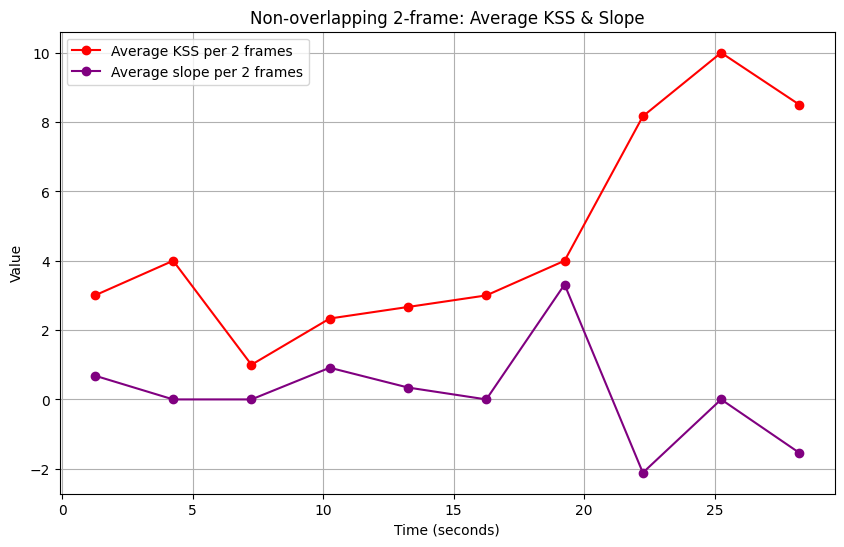

In [5]:
window_times = []
avg_kss_values = []  # 각 윈도우의 평균 KSS 값을 저장할 리스트
avg_slopes = []

non_overlap_size = WINDOW_SIZE  # 예: 10 프레임

for start in range(0, len(time_points), non_overlap_size):
    end = start + non_overlap_size
    if end <= len(time_points):
        x_window = np.array(time_points[start:end]) * 0.5  # 초 단위
        y_window = np.array(kss_values[start:end])
        
        avg_kss = y_window.mean()
        slope, intercept = np.polyfit(x_window, y_window, 1)
        
        window_times.append(np.mean(x_window))
        avg_kss_values.append(avg_kss)
        avg_slopes.append(slope)

plt.figure(figsize=(10, 6))
plt.plot(window_times, avg_kss_values, marker='o', color='red', label="Average KSS per 2 frames")
plt.plot(window_times, avg_slopes, marker='o', color='purple', label="Average slope per 2 frames")
plt.xlabel("Time (seconds)")
plt.ylabel("Value")
plt.title("Non-overlapping 2-frame: Average KSS & Slope")
plt.legend()
plt.grid(True)
plt.show()


[np.float64(3.0), np.float64(4.0), np.float64(1.0), np.float64(2.3333333333333335), np.float64(2.6666666666666665), np.float64(3.0), np.float64(4.0), np.float64(8.166666666666666), np.float64(10.0), np.float64(8.5)]
